# 이미지 로드 <br>

<br>
두 가지 방법으로 이미지 데이터세트를 로드하고 전처리하는 방법을 보여준다. <br>
1. keras 전처리 유틸리티 및 레이어 <br>
2. tf.data 사용하여 자체 입력 파이프라인 작성


In [ ]:
# 설정
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

In [ ]:
print(tf.__version__)

2.4.1


flowers_photos/ 이 데이터 셋 안에는 5개의 클래스가 있다. <br> 
  daisy ,  dandelion(민들레) ,   roses ,  sunflowers ,  tulips

CC-BY 라이선스(creative commons license) : 창작물에 대하여 일정한 조건 하에 다른 사람의 자유로운 이용을 허락하는 내용의 자유이용 라이선스 <br>

크리에이터는 LICENSE.txt 파일에 나열된다.  = 사용자는 텍스트 파일에 적히는건지? (명단)

In [ ]:
# 꽃 데이터세트 다운로드
import pathlib # 객체 지향 파일 시스템 경로
# os와 같은 역할
# 다른 운영 체제에 적합한 의미 체계를 가진 파일 시스템 경로를 나타내는 클래스 (파일경로를 문자열이 아닌 객체로 다룬다.)
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url, 
                                   fname='flower_photos', 
                                   untar=True)
print(data_dir)
data_dir = pathlib.Path(data_dir)

/root/.keras/datasets/flower_photos


In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)
#총 3670 장

3670


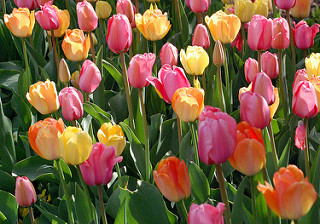

In [ ]:
roses = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(roses[1]))

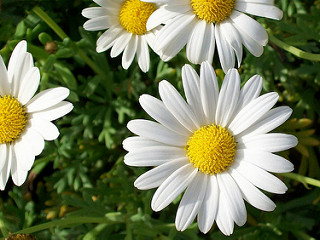

In [ ]:
roses = list(data_dir.glob('daisy/*'))
PIL.Image.open(str(roses[0]))

<h3>1.  keras.preprocessing을 사용하여 로드 </h3>
 <br>
 데이터세트 만들기

In [ ]:
# 매개변수 정의

# 배치 사이즈
batch_size = 32
# 크기
img_height = 180
img_width = 180 

In [ ]:
# validation_ split (검증분할)
# train 80 %  validation 20%

# 훈련 데이터
train_ds = tf.keras.preprocessing.image_dataset_from_directory( 
    data_dir,
    validation_split = 0.2, 
    subset = "training",
    seed = 123,
    image_size = (img_height,img_width),
    batch_size = batch_size )

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [ ]:
3670*0.8

2936.0

In [ ]:
# 검증 데이터 
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [ ]:
3670 *0.2

734.0

In [ ]:
class_names = train_ds.class_names
print(class_names) # 클래스 이름

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


<h3>데이터 시각화 </h3> 

<TakeDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.int32)>


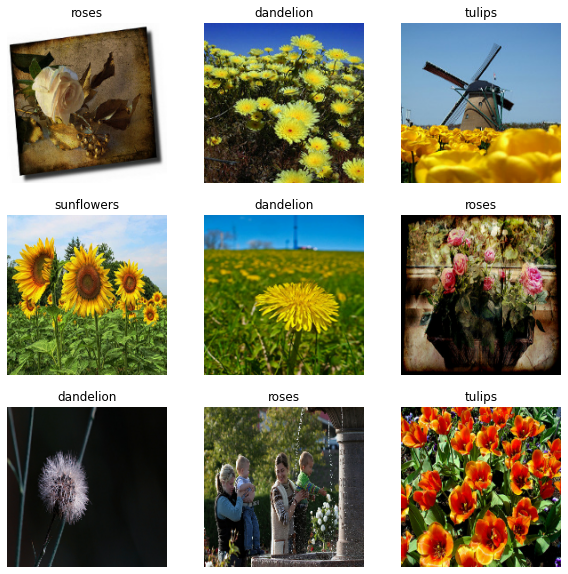

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
print (train_ds.take(1))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break
# 앞에서 batch size를 32로 지정
# 180x180 크기의 색상 채널 RGB를 나타낸다.
# (크기 , 가로, 세로, 색상)

(32, 180, 180, 3)
(32,)


<h3> 데이터 표준화하기 </h3>
RGB채널 값은 0~255 범위에 있다. <br>
신경망에 넣기 위해서는 입력값을 작게 만드는 것이 좋기에 0~1 사이의 있도록 표준화 한다. 

In [ ]:
from tensorflow.keras import layers

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255) 
# 픽셀 값은 [-1,1]로 조정하려면 Rescaling(1./127.5, offset = -1)

In [ ]:
print(normalization_layer)

normalization_layer 를 사용하는 방법은 2가지가 있다. <br>
<br>
1. map을 호출하여 데이터세트에 레이어를 적용

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y)) 
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[1]
print(np.min(first_image), np.max(first_image))

0.0 0.9986115


2. 모델 정의 내에 레이어를 포함하여 배포를 단순화 <br>
(여기서는 두번 째 접근방식 사용)

note : 모델에 크기 조정 옵션을 포함하려면 Reasizing 레이어를 대신 사용할수 있다. <br>
tf.keras.layers.experimental.preprocessing.Resizing( <br>
    height, width, interpolation='bilinear', name=None, **kwargs <br>
)

<h3> 성능을 위한 데이터세트 구성하기 </h3>

데이터를 로드 할 때 사용해야 하는 두 가지 중요한 메서드 <br>
1. .cache() : 첫 번째 epoch동안 디스크에서 이미지를 로드한 후 이미지를 메모리에 유지 <br> -> 모델 훈련하는 동안 데이터세트가 병목 상태가 되지 않는다. <br>
2. .prefetch() : 훈련 중에 데이터 전처리 및 모델 실행을 같이한다.  


In [ ]:
# tf.data.API 성능가이드에 있는 방법
AUTOTUNE = tf.data.experimental.AUTOTUNE
# 어떤 수준의 병렬처리가 tf.data 런타임에 사용되는지에 대해 결정한다. 


train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
print(AUTOTUNE)

-1


<h4> 모델 훈련하기 </h4>


In [ ]:
# CNN 모델
num_classes = 5

model = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [ ]:
model.fit(
  train_ds,
  batch_size=batch_size,
  validation_data=val_ds,
  epochs=3
)
# 검증 정확성 : 61% 
# 훈련 정확성 : 64% 
# 과대적합이 되었다. 저번에 했던 방법으로 줄일 수 있다. 

Epoch 1/3
92/92 [==============================] - 2s 17ms/step - loss: 1.4787 - accuracy: 0.3536 - val_loss: 1.1629 - val_accuracy: 0.5082
Epoch 2/3
92/92 [==============================] - 1s 15ms/step - loss: 1.0495 - accuracy: 0.5702 - val_loss: 1.0190 - val_accuracy: 0.5790
Epoch 3/3
92/92 [==============================] - 1s 15ms/step - loss: 0.8989 - accuracy: 0.6473 - val_loss: 0.9849 - val_accuracy: 0.6185


------
<h3> 미세 제어를 위해 tf.data 사용하기 </h3>
지금까지한 keras.preprocessing 유틸리티는 이미지의 디렉토리에서 tf.data.Dataset을 작성하는 편리한 방법 <br>
이것 보다 세밀한 제어를 하기 위해서는 tf.data을 사용해서 자체 입력 파이프라인을 작성할 수 있다. 

In [ ]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False) # 과정 보여줄려고 shuffle를 안한 것인지.. 모르겠음..
for f in list_ds.take(5):
    print(f.numpy())
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

b'/root/.keras/datasets/flower_photos/daisy/100080576_f52e8ee070_n.jpg'
b'/root/.keras/datasets/flower_photos/daisy/10140303196_b88d3d6cec.jpg'
b'/root/.keras/datasets/flower_photos/daisy/10172379554_b296050f82_n.jpg'
b'/root/.keras/datasets/flower_photos/daisy/10172567486_2748826a8b.jpg'
b'/root/.keras/datasets/flower_photos/daisy/10172636503_21bededa75_n.jpg'


In [ ]:
for f in list_ds.take(5):
    print(f.numpy())

b'/root/.keras/datasets/flower_photos/dandelion/17161833794_e1d92259d2_m.jpg'
b'/root/.keras/datasets/flower_photos/tulips/16680927427_07ca6e4552_n.jpg'
b'/root/.keras/datasets/flower_photos/sunflowers/4831577091_f56157a5d5_n.jpg'
b'/root/.keras/datasets/flower_photos/roses/2501297526_cbd66a3f7e_m.jpg'
b'/root/.keras/datasets/flower_photos/dandelion/10828951106_c3cd47983f.jpg'


In [ ]:
# 파일의 트리 구조를 사용해 class_names 목록을 컴파일 할 수 있다.
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)

['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


In [ ]:
# 훈련 및 검증으로 분할
val_size = int(image_count * 0.2)
print('val_size: ',val_size )
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

val_size:  734


In [ ]:
# 데이터 세트의 길이 확인
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

2936
734


In [ ]:
# 파일 경로를 (img,label)쌍으로 변환하는 간단한 함수
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    one_hot = parts[-2] == class_names
    return tf.argmax(one_hot)

def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3)
    return tf.image.resize(img, [img_height, img_width])

def process_path(file_path):
    label = get_label(file_path) # 호출
    img = tf.io.read_file(file_path)
    img = decode_img(img) # 호출 
    return img, label

In [ ]:
# Dataset.map을 사용해서 image, label 쌍의 데이터세트를 작성
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [ ]:
for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  4


<h3> 성능을 위한 데이터세트 구성하기 </h3>
이 데이터세트로 모델을 훈련할려면 데이터에 대해 다음이 필요 <br>
1. 잘 섞는다.<br>
2. 배치 처리한다. <br>
3. 가능한 빨리 배치를 사용할 수 있어야 한다. <br>
>  이러한 기능은 tf.data API를 사용해 추가

In [ ]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000) #잘 섞는다.
  ds = ds.batch(batch_size) # 배치 처리 
  ds = ds.prefetch(buffer_size=AUTOTUNE) # 가능한 빨리 배치를 사용?
  # prefetch :  소프트웨어 파이프라이닝 방법 제공 함수
  # 데이터가 소비되는 시간과 데이터가 생성되는 시간 간의 의존성을 줄인다. 
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

<h4> 데이터 시각화하기 </h4> 

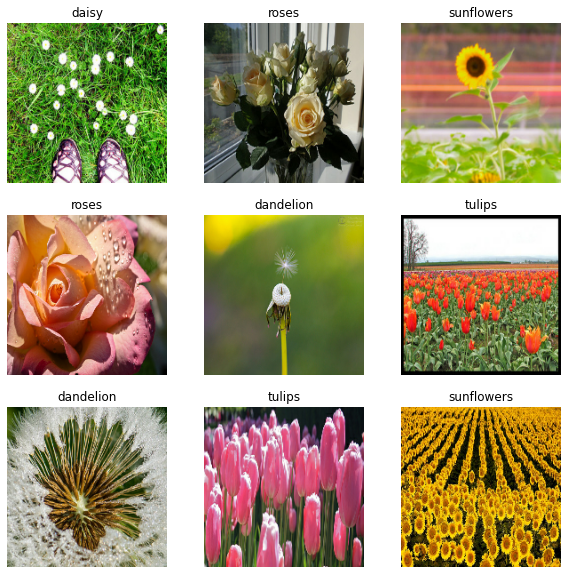

In [ ]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

<h3> 모델 계속 훈련하기 </h3>


In [ ]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
) # 실행시간을 짧게 유지하기 위해 3 epoch

# 검증 정확도 : 69%
# 훈련 정확도 : 84%  
# 과대적합 

Epoch 1/3
92/92 [==============================] - 10s 91ms/step - loss: 0.7954 - accuracy: 0.7010 - val_loss: 0.7533 - val_accuracy: 0.7071
Epoch 2/3
92/92 [==============================] - 2s 19ms/step - loss: 0.6025 - accuracy: 0.7844 - val_loss: 0.7561 - val_accuracy: 0.7166
Epoch 3/3
92/92 [==============================] - 2s 19ms/step - loss: 0.4335 - accuracy: 0.8426 - val_loss: 0.8911 - val_accuracy: 0.6975


In [ ]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=100
)  # 훈련정확도 : 99.9%  #검증정확도 : 67.4%

92/92 [==============================] - 2s 19ms/step - loss: 5.5503e-04 - accuracy: 0.9993 - val_loss: 3.0316 - val_accuracy: 0.6757
Epoch 95/100
92/92 [==============================] - 2s 19ms/step - loss: 5.5224e-04 - accuracy: 0.9997 - val_loss: 3.0433 - val_accuracy: 0.6771
Epoch 96/100
92/92 [==============================] - 2s 19ms/step - loss: 5.3903e-04 - accuracy: 0.9997 - val_loss: 3.0633 - val_accuracy: 0.6730
Epoch 97/100
92/92 [==============================] - 2s 19ms/step - loss: 5.3003e-04 - accuracy: 0.9993 - val_loss: 3.0800 - val_accuracy: 0.6730
Epoch 98/100
92/92 [==============================] - 2s 19ms/step - loss: 5.1907e-04 - accuracy: 0.9993 - val_loss: 3.0938 - val_accuracy: 0.6703
Epoch 99/100
92/92 [==============================] - 2s 19ms/step - loss: 5.3589e-04 - accuracy: 0.9997 - val_loss: 3.1076 - val_accuracy: 0.6730
Epoch 100/100
92/92 [==============================] - 2s 19ms/step - loss: 5.3406e-04 - accuracy: 0.9993 - val_loss: 3.1231 - val_

<h3> TensorFlow 데이터세트 사용하기 </h3>
- 지금까지는 디스크에서 데이터를 로드했다. <br>
- tensorflow 데이터 세트에서 다운로드하기 쉬운 대규모 데이터세트 카탈로그를 탐색하여 사용할 데이터 세트를 찾을 수도 있다. 

In [ ]:
# tensorflow 데이터세트를 사용하여 꽃 데이터세트를 다운
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'], # 훈련 80 % / 검증 10 % / 테스트 10%
    with_info=True,
    as_supervised=True,
)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [ ]:
# 꽃 데이터세트에는 5개의 클래스가 있다
num_classes = metadata.features['label'].num_classes
print(num_classes)

5


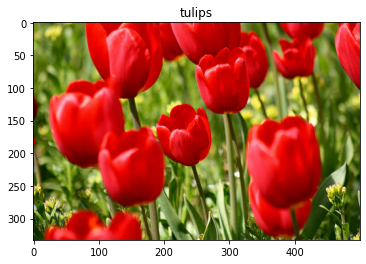

In [ ]:
# 데이터세트에서 이미지 시각화
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

In [ ]:
# 성능을 위해 각 데이터 세트를 일괄 처리, 셔플 및 구성해야한다.
train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)
test_ds = configure_for_performance(test_ds)

---------


---



---



---




# CSV 데이터 로드 

- tf.data.Dataset로 CSV 데이터를 로드하는 방법의 예를 제공<br>
- 타이타닉 승객 목록 데이터 사용 <br>
<br>
[ 타이타닉 모델 ] <br>
- 연령, 성별, 티켓 등급 및 단독 여행 여부와 같은 특성을 기반으로 승객의 생존 가능성 예측

In [4]:
import functools
import numpy as np
import tensorflow as tf

In [5]:
TRAIN_DATA_URL = "https://storage.googleapis.com/tf-datasets/titanic/train.csv"
TEST_DATA_URL = "https://storage.googleapis.com/tf-datasets/titanic/eval.csv"

train_file_path = tf.keras.utils.get_file("train.csv", TRAIN_DATA_URL)
test_file_path = tf.keras.utils.get_file("eval.csv", TEST_DATA_URL)

16384/13049 [=====================================] - 0s 0us/step


In [6]:
np.set_printoptions(precision=3, suppress=True) #숫자값을 읽기 쉽게 하기위해 numpy를 이용

<h3> 데이터 로드하기 </h3>


In [7]:
# csv파일의 상단을 보고 형식이 어떻게 지정되는지 확인
!head {train_file_path}

survived,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.25,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
1,female,26.0,0,0,7.925,Third,unknown,Southampton,y
1,female,35.0,1,0,53.1,First,C,Southampton,n
0,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y
0,male,2.0,3,1,21.075,Third,unknown,Southampton,n
1,female,27.0,0,2,11.1333,Third,unknown,Southampton,n
1,female,14.0,1,0,30.0708,Second,unknown,Cherbourg,n
1,female,4.0,1,1,16.7,Third,G,Southampton,n


In [8]:
# pandas 로드하고 numpy 배열을 tensorflow에 전달 할 수 있다. 
# pd.read_csv ('file_name')

# 큰 파일 세트로 확장해야 하거나 Tensorflow 및  tf.data와 통합되는 로더가 필요한 경우
# tf.data.experimental.make_csv_dataset 


# 모델로 예측할려는 값이 있는 열 (종속변수)
LABEL_COLUMN = 'survived'
LABELS = [0, 1]

In [9]:
# csv 데이터 읽고 데이터세트를 작성

def get_dataset(file_path, **kwargs): 
  dataset = tf.data.experimental.make_csv_dataset(
      file_path,
      batch_size=5,
      label_name=LABEL_COLUMN,
      na_value="?",  # nan으로 인식할 추가 문자열
      #num_epochs=1, 
      ignore_errors=True, 
      # True이면 잘못된 형식의 데이터, 빈 값은 오류를 무시하고 넘어감 (예외처리) default:false
      **kwargs)
      # kwargs == keyword argument : {'키워드':'특정 값} 형태의 딕셔너리 형태로 함수 내부에 전달 
      # 옵션값을 더 추가할 때 사용 
  return dataset

raw_train_data = get_dataset(train_file_path,num_epochs=1)
raw_test_data = get_dataset(test_file_path,num_epochs=1)

In [10]:
def show_batch(dataset):
  for batch, label in dataset.take(1):
    for key, value in batch.items():
      print("{:20s}: {}".format(key,value.numpy()))
    # csv 데이터를 읽을 때 batch_size를 5로 하여 5개값만 나옴

In [11]:
show_batch(raw_train_data)

sex                 : [b'male' b'male' b'male' b'male' b'male']
age                 : [28. 28. 30. 36. 21.]
n_siblings_spouses  : [0 0 1 1 0]
parch               : [0 1 0 0 0]
fare                : [ 8.05  33.    16.1   78.85   7.925]
class               : [b'Third' b'Second' b'Third' b'First' b'Third']
deck                : [b'unknown' b'unknown' b'unknown' b'C' b'unknown']
embark_town         : [b'Southampton' b'Southampton' b'Southampton' b'Southampton'
 b'Southampton']
alone               : [b'y' b'n' b'n' b'n' b'y']


In [12]:
# 파일 첫번째 행을 열 이름으로 지정
# 파일의 열이름이 없는 경우는 column_names 을 이용하면 열이름을 만들 수 있다.

CSV_COLUMNS = ['survived', 'sex', 'age', 'n_siblings_spouses', 'parch', 'fare', 'class', 'deck', 'embark_town', 'alone']

temp_dataset = get_dataset(train_file_path, column_names=CSV_COLUMNS)

show_batch(temp_dataset)

sex                 : [b'female' b'male' b'male' b'female' b'male']
age                 : [28. 28. 28.  9. 28.]
n_siblings_spouses  : [0 0 0 3 0]
parch               : [0 0 0 2 0]
fare                : [13.     7.25   7.733 27.9    0.   ]
class               : [b'Second' b'Third' b'Third' b'Third' b'Second']
deck                : [b'unknown' b'unknown' b'unknown' b'unknown' b'unknown']
embark_town         : [b'Southampton' b'Southampton' b'Queenstown' b'Southampton' b'Southampton']
alone               : [b'y' b'y' b'y' b'n' b'y']


In [13]:
# 모든 열 말고 일부분만 사용할려면 select_columns 사용
# 그대신 파일의 열 이름이 지정되어 있어야한다.

SELECT_COLUMNS = ['survived', 'age', 'n_siblings_spouses', 'class', 'deck', 'alone']

temp_dataset = get_dataset(train_file_path, select_columns=SELECT_COLUMNS)

show_batch(temp_dataset)

age                 : [ 7. 28. 11. 62. 35.]
n_siblings_spouses  : [4 0 4 0 0]
class               : [b'Third' b'Third' b'Third' b'Second' b'Third']
deck                : [b'unknown' b'unknown' b'unknown' b'unknown' b'unknown']
alone               : [b'n' b'y' b'n' b'y' b'y']


<h3> 데이터 전처리 </h3>

데이터를 모델에 넣기 전에 고정길이 벡터로 변환 <br>
<br>
- 모델 내에서 전처리를 수행할 때의 주요 이점 <br>
  - 모델을 내보낼 때 전처리가 포함된다.
  <br>\> 원시데이터를 모델로 직접 전달할 수 있다.


In [14]:
# 연속데이터
# 데이터가 숫자 형식인 경우 -> 벡터로 묶음

SELECT_COLUMNS = ['survived', 'age', 'n_siblings_spouses', 'parch', 'fare'] #숫자가 있는 컬럼만 모아옴
DEFAULTS = [0, 0.0, 0.0, 0.0, 0.0]
temp_dataset = get_dataset(train_file_path, 
                           select_columns=SELECT_COLUMNS,
                           column_defaults = DEFAULTS)

show_batch(temp_dataset)

age                 : [28. 18. 25. 28. 16.]
n_siblings_spouses  : [0. 1. 0. 0. 0.]
parch               : [0. 0. 0. 0. 0.]
fare                : [ 7.854 17.8    7.65   7.225  8.05 ]


In [15]:
example_batch, labels_batch = next(iter(temp_dataset))

In [16]:
print('example_batch', example_batch)
print('labels_batch', labels_batch)

example_batch OrderedDict([('age', <tf.Tensor: shape=(5,), dtype=float32, numpy=array([48., 45., 28., 60., 41.], dtype=float32)>), ('n_siblings_spouses', <tf.Tensor: shape=(5,), dtype=float32, numpy=array([1., 1., 1., 1., 0.], dtype=float32)>), ('parch', <tf.Tensor: shape=(5,), dtype=float32, numpy=array([0., 1., 0., 1., 0.], dtype=float32)>), ('fare', <tf.Tensor: shape=(5,), dtype=float32, numpy=array([39.6  , 26.25 , 82.171, 39.   ,  7.125], dtype=float32)>)])
labels_batch tf.Tensor([1 1 0 0 0], shape=(5,), dtype=int32)


In [17]:
# 모든 열을 묶는 함수
def pack(features, label):
  return tf.stack(list(features.values()), axis=-1), label

In [18]:
show_batch(temp_dataset.take(1)) # 랜덤값

age                 : [27. 28. 18. 30. 24.]
n_siblings_spouses  : [0. 0. 0. 0. 0.]
parch               : [0. 0. 0. 0. 0.]
fare                : [ 30.5   227.525   9.842  27.75   69.3  ]


In [19]:
packed_dataset = temp_dataset.map(pack)

for features, labels in packed_dataset.take(1):
  print(features.numpy())
  print()
  print(labels.numpy())

[[ 15.      0.      1.    211.337]
 [ 50.      0.      0.     10.5  ]
 [ 28.      0.      0.      8.05 ]
 [ 28.      1.      0.    146.521]
 [ 19.      3.      2.    263.   ]]

[1 1 0 1 0]


In [20]:
# 혼합 데이터 유형인 경우
# 숫자 필드 분리 
# tf.feature_column API로 처리하면 오버헤드가 발생하여 가급적 사용 x 
show_batch(raw_train_data)

sex                 : [b'female' b'male' b'female' b'male' b'female']
age                 : [28. 28. 35. 39. 52.]
n_siblings_spouses  : [1 0 1 0 1]
parch               : [0 1 1 0 1]
fare                : [133.65  33.    20.25  26.    93.5 ]
class               : [b'First' b'Second' b'Third' b'Second' b'First']
deck                : [b'unknown' b'unknown' b'unknown' b'unknown' b'B']
embark_town         : [b'Southampton' b'Southampton' b'Southampton' b'Southampton'
 b'Southampton']
alone               : [b'n' b'n' b'n' b'y' b'n']


In [21]:
example_batch, labels_batch = next(iter(temp_dataset))

In [22]:
# 전처리기
class PackNumericFeatures(object):
  def __init__(self, names):
    self.names = names

  def __call__(self, features, labels):
    numeric_features = [features.pop(name) for name in self.names]
    numeric_features = [tf.cast(feat, tf.float32) for feat in numeric_features]
    numeric_features = tf.stack(numeric_features, axis=-1)
    features['numeric'] = numeric_features

    return features, labels

In [23]:
NUMERIC_FEATURES = ['age','n_siblings_spouses','parch', 'fare']

packed_train_data = raw_train_data.map(
    PackNumericFeatures(NUMERIC_FEATURES))

packed_test_data = raw_test_data.map(
    PackNumericFeatures(NUMERIC_FEATURES))

# 숫자열만 골라서 묶음
show_batch(packed_train_data)

sex                 : [b'male' b'male' b'male' b'female' b'male']
class               : [b'Third' b'First' b'Third' b'Second' b'Third']
deck                : [b'unknown' b'D' b'unknown' b'unknown' b'unknown']
embark_town         : [b'Southampton' b'Southampton' b'Southampton' b'Southampton'
 b'Southampton']
alone               : [b'n' b'y' b'y' b'n' b'y']
numeric             : [[22.     1.     0.     7.25 ]
 [61.     0.     0.    32.321]
 [39.     0.     0.    24.15 ]
 [48.     1.     2.    65.   ]
 [26.     0.     0.     7.896]]


In [24]:
example_batch, labels_batch = next(iter(packed_train_data))

In [25]:
# 데이터 정규화

# 연속 데이터는 항상 정규화되어야 한다.

import pandas as pd
# 숫자값만 있는 열들 불러옴 
desc = pd.read_csv(train_file_path)[NUMERIC_FEATURES].describe()
desc

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


In [26]:
MEAN = np.array(desc.T['mean'])
STD = np.array(desc.T['std'])

In [27]:
print(MEAN)
print(desc.T['mean'])

[29.631  0.545  0.38  34.385]
age                   29.631308
n_siblings_spouses     0.545455
parch                  0.379585
fare                  34.385399
Name: mean, dtype: float64


In [28]:
def normalize_numeric_data(data, mean, std):
  return (data-mean)/std # 표준화 

In [29]:
# 숫자 열을 만든다.
# tf.feature_columns.numeric_column : 각 배치에서 실행될 normalizer_fn 인수 허용 
# functools.partial : 원래 있는 함수에 인수를 추가 

normalizer = functools.partial(normalize_numeric_data, mean=MEAN, std=STD) # normalize_numeric_data를 5번 실행
print('normalizer ',normalizer)

numeric_column = tf.feature_column.numeric_column('numeric', normalizer_fn=normalizer, shape=[len(NUMERIC_FEATURES)])
numeric_columns = [numeric_column]
numeric_column

normalizer  functools.partial(<function normalize_numeric_data at 0x7fc5e015d200>, mean=array([29.631,  0.545,  0.38 , 34.385]), std=array([12.512,  1.151,  0.793, 54.598]))


NumericColumn(key='numeric', shape=(4,), default_value=None, dtype=tf.float32, normalizer_fn=functools.partial(<function normalize_numeric_data at 0x7fc5e015d200>, mean=array([29.631,  0.545,  0.38 , 34.385]), std=array([12.512,  1.151,  0.793, 54.598])))

In [30]:
# functools.partial example
def power(base, exponent):
    return base ** exponent

square = functools.partial(power, exponent=2)
cube = functools.partial(power, exponent=3)

print(square)
print(cube)
print(square(2))
print(cube(2))

functools.partial(<function power at 0x7fc5e015d7a0>, exponent=2)
functools.partial(<function power at 0x7fc5e015d7a0>, exponent=3)
4
8


In [31]:
example_batch

OrderedDict([('sex',
              <tf.Tensor: shape=(5,), dtype=string, numpy=array([b'male', b'female', b'male', b'male', b'male'], dtype=object)>),
             ('class',
              <tf.Tensor: shape=(5,), dtype=string, numpy=array([b'Third', b'Second', b'Third', b'Third', b'Third'], dtype=object)>),
             ('deck', <tf.Tensor: shape=(5,), dtype=string, numpy=
              array([b'unknown', b'unknown', b'unknown', b'unknown', b'unknown'],
                    dtype=object)>),
             ('embark_town', <tf.Tensor: shape=(5,), dtype=string, numpy=
              array([b'Southampton', b'Cherbourg', b'Southampton', b'Southampton',
                     b'Southampton'], dtype=object)>),
             ('alone',
              <tf.Tensor: shape=(5,), dtype=string, numpy=array([b'y', b'n', b'y', b'n', b'y'], dtype=object)>),
             ('numeric', <tf.Tensor: shape=(5, 4), dtype=float32, numpy=
              array([[23.   ,  0.   ,  0.   ,  7.896],
                     [28.   , 

In [32]:
# 모델을 훈련할 때 숫자 데이터 블록을 선택 
example_batch['numeric']

<tf.Tensor: shape=(5, 4), dtype=float32, numpy=
array([[23.   ,  0.   ,  0.   ,  7.896],
       [28.   ,  1.   ,  0.   , 24.   ],
       [36.   ,  0.   ,  0.   ,  7.496],
       [26.   ,  2.   ,  0.   ,  8.663],
       [28.   ,  0.   ,  0.   ,  7.25 ]], dtype=float32)>

In [33]:
numeric_layer = tf.keras.layers.DenseFeatures(numeric_columns)
numeric_layer(example_batch).numpy()

# 여기서 사용한 평균 기반 정규화를 하기 위해서는 각 열의 평균을 미리 알아야한다.

array([[-0.53 , -0.474, -0.479, -0.485],
       [-0.13 ,  0.395, -0.479, -0.19 ],
       [ 0.509, -0.474, -0.479, -0.493],
       [-0.29 ,  1.264, -0.479, -0.471],
       [-0.13 , -0.474, -0.479, -0.497]], dtype=float32)

<h4> 범주형 데이터</h4>

tf.feature_column API를 사용하여 각 범주 열에 대해 tf.feature_column.indicator_column 작성
<br> <br>
[ example ] <br>
name = indicator_column(categorical_column_with_vocabulary_list(
    'name', ['bob', 'george', 'wanda']))<br>
columns = [name, ...]<br>
features = tf.io.parse_example(..., features=make_parse_example_spec(columns))<br>
dense_tensor = input_layer(features, columns)<br>
<br><br>
dense_tensor == [[1, 0, 0]]  # If "name" bytes_list is ["bob"]<br>
dense_tensor == [[1, 0, 1]]  # If "name" bytes_list is ["bob", "wanda"]<br>
dense_tensor == [[2, 0, 0]]  # If "name" bytes_list is ["bob", "bob"]

In [34]:
CATEGORIES = {
    'sex': ['male', 'female'],
    'class' : ['First', 'Second', 'Third'],
    'deck' : ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J'],
    'embark_town' : ['Cherbourg', 'Southhampton', 'Queenstown'],
    'alone' : ['y', 'n']
}

In [35]:
categorical_columns = []
for feature, vocab in CATEGORIES.items():
  cat_col = tf.feature_column.categorical_column_with_vocabulary_list(
        key=feature, vocabulary_list=vocab)
  categorical_columns.append(tf.feature_column.indicator_column(cat_col))

In [36]:
categorical_columns

[IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='sex', vocabulary_list=('male', 'female'), dtype=tf.string, default_value=-1, num_oov_buckets=0)),
 IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='class', vocabulary_list=('First', 'Second', 'Third'), dtype=tf.string, default_value=-1, num_oov_buckets=0)),
 IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='deck', vocabulary_list=('A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J'), dtype=tf.string, default_value=-1, num_oov_buckets=0)),
 IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='embark_town', vocabulary_list=('Cherbourg', 'Southhampton', 'Queenstown'), dtype=tf.string, default_value=-1, num_oov_buckets=0)),
 IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='alone', vocabulary_list=('y', 'n'), dtype=tf.string, default_value=-1, num_oov_buckets=0))]

In [37]:
categorical_layer = tf.keras.layers.DenseFeatures(categorical_columns)
print(categorical_layer(example_batch).numpy()[0])

[1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


In [38]:
# 결합된 전처리 레이어

# tf.keras.layers.DenseFeatures 에 결합할 열 모음을 넣으면 
# 결합한 열 모음의 유형과 전처리할 입력 레이어를 만든다. 

preprocessing_layer = tf.keras.layers.DenseFeatures(categorical_columns+numeric_columns)

print(preprocessing_layer(example_batch).numpy()[0])

[ 1.     0.     0.     0.     1.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     0.     0.     0.    -0.53  -0.474
 -0.479 -0.485  1.     0.   ]


In [39]:
preprocessing_layer = tf.keras.layers.DenseFeatures(categorical_columns)

print(preprocessing_layer(example_batch).numpy()[0])

preprocessing_layer = tf.keras.layers.DenseFeatures(numeric_columns)

print(preprocessing_layer(example_batch).numpy()[0])

[1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
[-0.53  -0.474 -0.479 -0.485]


<h3> 모델 빌드하기 </h3>

preprocessing_layer를 사용하여 tf.keras.Sequential를 빌드


In [40]:
model = tf.keras.Sequential([
  preprocessing_layer,
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(1),
])

model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy'])

<h3> 훈련, 평가 및 예측 </h3>


In [41]:
train_data = packed_train_data.shuffle(500)
test_data = packed_test_data

In [42]:
model.fit(train_data, epochs=100)
# 훈련 정확도 75.7%

126/126 [==============================] - 0s 3ms/step - loss: 0.4810 - accuracy: 0.7681
Epoch 71/100
126/126 [==============================] - 0s 2ms/step - loss: 0.4574 - accuracy: 0.7875
Epoch 72/100
126/126 [==============================] - 0s 2ms/step - loss: 0.4719 - accuracy: 0.7749
Epoch 73/100
126/126 [==============================] - 0s 2ms/step - loss: 0.4872 - accuracy: 0.7550
Epoch 74/100
126/126 [==============================] - 0s 3ms/step - loss: 0.4772 - accuracy: 0.7788
Epoch 75/100
126/126 [==============================] - 0s 2ms/step - loss: 0.5066 - accuracy: 0.7485
Epoch 76/100
126/126 [==============================] - 0s 3ms/step - loss: 0.4766 - accuracy: 0.7612
Epoch 77/100
126/126 [==============================] - 0s 3ms/step - loss: 0.4774 - accuracy: 0.7834
Epoch 78/100
126/126 [==============================] - 0s 2ms/step - loss: 0.4848 - accuracy: 0.7546
Epoch 79/100
126/126 [==============================] - 0s 2ms/step - loss: 0.4785 - accuracy: 

In [43]:
test_loss, test_accuracy = model.evaluate(test_data)

print('\n\nTest Loss {}, Test Accuracy {}'.format(test_loss, test_accuracy))
# test 정확성 : 73.8 %

Consider rewriting this model with the Functional API.
53/53 [==============================] - 0s 2ms/step - loss: 0.6060 - accuracy: 0.7311


Test Loss 0.6059827208518982, Test Accuracy 0.7310606241226196


In [44]:
# tf.keras.Model.predict 를 사용해 배치 데이터세트에서 레이블을 유추

predictions = model.predict(test_data)

for prediction, survived in zip(predictions[:10], list(test_data)[0][1][:10]):
  prediction = tf.sigmoid(prediction).numpy()
  print("Predicted survival: {:.2%}".format(prediction[0]),
        " | Actual outcome: ",
        ("SURVIVED" if bool(survived) else "DIED"))
  
#  20%로 죽었다는 뜻?

Consider rewriting this model with the Functional API.
Predicted survival: 17.09%  | Actual outcome:  SURVIVED
Predicted survival: 95.57%  | Actual outcome:  SURVIVED
Predicted survival: 50.14%  | Actual outcome:  DIED
Predicted survival: 28.67%  | Actual outcome:  DIED
Predicted survival: 29.03%  | Actual outcome:  SURVIVED


In [45]:
print(prediction[0])

0.2902549
